**Import relevant libraries**

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import numpy as np
import scipy.stats as st
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, KFold, RandomizedSearchCV
from sklearn.linear_model import RidgeCV, LassoCV, BayesianRidge
from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import SelectFromModel
from scipy.special import boxcox1p, inv_boxcox1p
from xgboost import XGBRegressor

**Load the data**

In [2]:
df_initial_train = pd.read_csv('train.csv')
# Keep the initial data untouched
df_train = df_initial_train.copy()
df_initial_test = pd.read_csv('test.csv')
df_test = df_initial_test.copy()
# Concat the test and train data so data cleansing can be done on the entire dataset all at once
df_train = pd.concat([df_train, df_test], ignore_index=True, sort=True)

**Convert nulls**

In [3]:
# Change Lot Frontage from NA to 0
df_train.loc[:, "LotFrontage"] = df_train.loc[:, "LotFrontage"].fillna(0)
# Change Alley from NA to None
df_train.loc[:, "Alley"] = df_train.loc[:, "Alley"].fillna("None")
# Change Masonry veneer type from NA to None
df_train.loc[:, "MasVnrType"] = df_train.loc[:, "MasVnrType"].fillna("None")
# Change Masonry veneer area from NA to 0
df_train.loc[:, "MasVnrArea"] = df_train.loc[:, "MasVnrArea"].fillna(0)
# Change 333 Basement Finish Type 2 to Unf (same as Type 1)
df_train.loc[332, "BsmtFinType2"] = 'Unf'
# Change Basement Quality from NaN to None
df_train.loc[:, "BsmtQual"] = df_train.loc[:, "BsmtQual"].fillna("None")
# Change Basement Condition from NaN to None
df_train.loc[:, "BsmtCond"] = df_train.loc[:, "BsmtCond"].fillna("None")
# Change Basement Finish Type 1 and 2 from NaN to None
df_train.loc[:, "BsmtFinType1"] = df_train.loc[:, "BsmtFinType1"].fillna(
    "None")
df_train.loc[:, "BsmtFinType2"] = df_train.loc[:, "BsmtFinType2"].fillna(
    "None")
# Change Basement Exposure from NaN to None
df_train.loc[:, "BsmtExposure"] = df_train.loc[:, "BsmtExposure"].fillna(
    "None")
# Change Fireplace Quality from NaN to None
df_train.loc[:, "FireplaceQu"] = df_train.loc[:, "FireplaceQu"].fillna("None")
# Change Garage Type from NaN to None
df_train.loc[:, "GarageType"] = df_train.loc[:, "GarageType"].fillna("None")
# Change Garage Finish from NaN to None
df_train.loc[:, "GarageFinish"] = df_train.loc[:, "GarageFinish"].fillna(
    "None")
# Change Garage Quality from NaN to None
df_train.loc[:, "GarageQual"] = df_train.loc[:, "GarageQual"].fillna("None")
# Change Garage Condition from NaN to None
df_train.loc[:, "GarageCond"] = df_train.loc[:, "GarageCond"].fillna("None")
# Change Pool Quality from NaN to None
df_train.loc[:, "PoolQC"] = df_train.loc[:, "PoolQC"].fillna("None")
# Change Fence from NaN to None
df_train.loc[:, "Fence"] = df_train.loc[:, "Fence"].fillna("None")
# Change Misc Feature from NaN to None
df_train.loc[:, "MiscFeature"] = df_train.loc[:, "MiscFeature"].fillna("None")
# Change Garage Year built to same as Year Built
df_train.loc[:, "GarageYrBlt"] = df_train.loc[:, "GarageYrBlt"].fillna(
    df_train['YearBuilt'])

# Additional required for test data
# Change MSZoning from NaN to RL (most common)
df_train.loc[:, "MSZoning"] = df_train.loc[:, "MSZoning"].fillna("RL")
# Change Utilities from NaN to AllPub (most common)
df_train.loc[:, "Utilities"] = df_train.loc[:, "Utilities"].fillna("AllPub")
# Change basement NaN to 0 as its all for one record
df_train.loc[:, "BsmtFinSF1"] = df_train.loc[:, "BsmtFinSF1"].fillna(0)
df_train.loc[:, "BsmtFinSF2"] = df_train.loc[:, "BsmtFinSF2"].fillna(0)
df_train.loc[:, "BsmtUnfSF"] = df_train.loc[:, "BsmtUnfSF"].fillna(0)
df_train.loc[:, "TotalBsmtSF"] = df_train.loc[:, "TotalBsmtSF"].fillna(0)
df_train.loc[:, "BsmtFullBath"] = df_train.loc[:, "BsmtFullBath"].fillna(0)
df_train.loc[:, "BsmtHalfBath"] = df_train.loc[:, "BsmtHalfBath"].fillna(0)
# Change Siding from NaN to VinylSd as its the most common
df_train.loc[:, "Exterior1st"] = df_train.loc[:, "Exterior1st"].fillna(
    "VinylSd")
df_train.loc[:, "Exterior2nd"] = df_train.loc[:, "Exterior2nd"].fillna(
    "VinylSd")
# Change KitchenQual from NaN to TA as its the most common
df_train.loc[:, "KitchenQual"] = df_train.loc[:, "KitchenQual"].fillna("TA")
# Change Functional from NaN to Typ as its the most common
df_train.loc[:, "Functional"] = df_train.loc[:, "Functional"].fillna("Typ")
# Change Garage from NaN to the mean
df_train.loc[:, "GarageCars"] = df_train.loc[:, "GarageCars"].fillna(
    df_train['GarageCars'].mean())
df_train.loc[:, "GarageArea"] = df_train.loc[:, "GarageArea"].fillna(
    df_train['GarageArea'].mean())
# Change SaleType from NaN to WD as its the most common
df_train.loc[:, "SaleType"] = df_train.loc[:, "SaleType"].fillna("WD")
# change 2550 as its year sold is earlier than year built
df_train.loc[2549, "YearBuilt"] = 2007
df_train.loc[2549, "YearRemodAdd"] = 2007
# change 2296 as its year sold is earlier than remodel
df_train.loc[2295, "YearRemodAdd"] = 2007

**Convert categorical features to strings**

Inspired by *A study on Regression applied to the Ames dataset*

In [4]:
df_train = df_train.replace({
    "MSSubClass": {
        20: "SC20",
        30: "SC30",
        40: "SC40",
        45: "SC45",
        50: "SC50",
        60: "SC60",
        70: "SC70",
        75: "SC75",
        80: "SC80",
        85: "SC85",
        90: "SC90",
        120: "SC120",
        150: "SC150",
        160: "SC160",
        180: "SC180",
        190: "SC190"
    },
    "MoSold": {
        1: "Jan",
        2: "Feb",
        3: "Mar",
        4: "Apr",
        5: "May",
        6: "Jun",
        7: "Jul",
        8: "Aug",
        9: "Sep",
        10: "Oct",
        11: "Nov",
        12: "Dec"
    }
})

**Make "exists" features**

exists_features = ({
    "Alley": {
        "None": 0,
        "Grvl": 1,
        "Pave": 1
    },
    "BsmtCond": {
        "None": 0,
        "No": 0,
        "Po": 1,
        "Fa": 1,
        "TA": 1,
        "Gd": 1,
        "Ex": 1
    },
    "ExterCond": {
        "None": 0,
        "Po": 1,
        "Fa": 1,
        "TA": 1,
        "Gd": 1,
        "Ex": 1
    },
    "FireplaceQu": {
        "None": 0,
        "No": 0,
        "Po": 1,
        "Fa": 1,
        "TA": 1,
        "Gd": 1,
        "Ex": 1
    },
    "GarageQual": {
        "None": 0,
        "No": 0,
        "Po": 1,
        "Fa": 1,
        "TA": 1,
        "Gd": 1,
        "Ex": 1
    },
    "HeatingQC": {
        "None": 0,
        "Po": 1,
        "Fa": 1,
        "TA": 1,
        "Gd": 1,
        "Ex": 1
    },
    "PavedDrive": {
        "N": 0,
        "P": 0,
        "Y": 1
    },
    "PoolQC": {
        "None": 0,
        "No": 0,
        "Fa": 1,
        "TA": 1,
        "Gd": 1,
        "Ex": 1
    },
    "Street": {
        "Grvl": 0,
        "Pave": 1
    },
    "MasVnrType": {
        "None": 0,
        "BrkCmn": 1,
        "BrkFace": 1,
        "Stone": 1
    },
    "Fence": {
        "None": 0,
        "GdPrv": 1,
        "MnPrv": 1,
        "GdWo": 1,
        "MnWw": 1
    },
    "CentralAir": {
        "N": 0,
        "Y": 1
    },
    "MiscFeature": {
        "None": 0,
        "Shed": 1,
        "Othr": 1,
        "Gar2": 1,
        "TenC": 1,
        "Elev": 1
    }
})

for key, value in exists_features.items():
    new_col_name = key + "_exists"
    df_train[new_col_name] = df_train[key].replace(value)

**Make features ordered**

Inspired by *A study on Regression applied to the Ames dataset* - added "None" and MasVnrType

In [5]:
ordered_features = ({
    "Alley": {
        "None": 0,
        "Grvl": 1,
        "Pave": 2
    },
    "BsmtCond": {
        "None": 0,
        "No": 0,
        "Po": 1,
        "Fa": 2,
        "TA": 3,
        "Gd": 4,
        "Ex": 5
    },
    "BsmtExposure": {
        "None": 0,
        "No": 0,
        "Mn": 1,
        "Av": 2,
        "Gd": 3
    },
    "BsmtFinType1": {
        "None": 0,
        "No": 0,
        "Unf": 1,
        "LwQ": 2,
        "Rec": 3,
        "BLQ": 4,
        "ALQ": 5,
        "GLQ": 6
    },
    "BsmtFinType2": {
        "None": 0,
        "No": 0,
        "Unf": 1,
        "LwQ": 2,
        "Rec": 3,
        "BLQ": 4,
        "ALQ": 5,
        "GLQ": 6
    },
    "BsmtQual": {
        "None": 0,
        "No": 0,
        "Po": 1,
        "Fa": 2,
        "TA": 3,
        "Gd": 4,
        "Ex": 5
    },
    "ExterCond": {
        "None": 0,
        "Po": 1,
        "Fa": 2,
        "TA": 3,
        "Gd": 4,
        "Ex": 5
    },
    "ExterQual": {
        "None": 0,
        "Po": 1,
        "Fa": 2,
        "TA": 3,
        "Gd": 4,
        "Ex": 5
    },
    "FireplaceQu": {
        "None": 0,
        "No": 0,
        "Po": 1,
        "Fa": 2,
        "TA": 3,
        "Gd": 4,
        "Ex": 5
    },
    "Functional": {
        "Sal": 1,
        "Sev": 2,
        "Maj2": 3,
        "Maj1": 4,
        "Mod": 5,
        "Min2": 6,
        "Min1": 7,
        "Typ": 8
    },
    "GarageCond": {
        "None": 0,
        "No": 0,
        "Po": 1,
        "Fa": 2,
        "TA": 3,
        "Gd": 4,
        "Ex": 5
    },
    "GarageQual": {
        "None": 0,
        "No": 0,
        "Po": 1,
        "Fa": 2,
        "TA": 3,
        "Gd": 4,
        "Ex": 5
    },
    "HeatingQC": {
        "None": 0,
        "Po": 1,
        "Fa": 2,
        "TA": 3,
        "Gd": 4,
        "Ex": 5
    },
    "KitchenQual": {
        "Po": 1,
        "Fa": 2,
        "TA": 3,
        "Gd": 4,
        "Ex": 5
    },
    "LandSlope": {
        "Sev": 1,
        "Mod": 2,
        "Gtl": 3
    },
    "LotShape": {
        "IR3": 1,
        "IR2": 2,
        "IR1": 3,
        "Reg": 4
    },
    "PavedDrive": {
        "N": 0,
        "P": 1,
        "Y": 2
    },
    "PoolQC": {
        "None": 0,
        "No": 0,
        "Fa": 1,
        "TA": 2,
        "Gd": 3,
        "Ex": 4
    },
    "Street": {
        "Grvl": 1,
        "Pave": 2
    },
    "Utilities": {
        "ELO": 1,
        "NoSeWa": 2,
        "NoSewr": 3,
        "AllPub": 4
    },
    "MasVnrType": {
        "None": 0,
        "BrkCmn": 1,
        "BrkFace": 2,
        "Stone": 3
    }
})

for key, value in ordered_features.items():
    new_col_name = key  #+"_ordered"
    df_train[new_col_name] = df_train[key].replace(value)

**Group features that don't have many examples**

In [6]:
group_other_features = ({
    "BldgType": {
        "TwnhsE": "Other",
        "Duplex": "Other",
        "Twnhs": "Other",
        "2fmCon": "Other"
    },
    "Condition1": {
        "Feedr": "Other",
        "Artery": "Other",
        "RRAn": "Other",
        "PosN": "Other",
        "RRAe": "Other",
        "PosA": "Other",
        "RRNn": "Other",
        "RRNe": "Other"
    },
    "Condition2": {
        "Feedr": "Other",
        "Artery": "Other",
        "PosN": "Other",
        "PosA": "Other",
        "RRNn": "Other",
        "RRAn": "Other",
        "RRAe": "Other"
    },
    "Electrical": {
        "FuseA": "Other",
        "FuseF": "Other",
        "FuseP": "Other",
        "Mix": "Other"
    },
    "Exterior1st": {
        "BrkComm": "Other",
        "AsphShn": "Other",
        "Stone": "Other",
        "CBlock": "Other",
        "ImStucc": "Other"
    },
    "Exterior2nd": {
        "BrkComm": "Other",
        "AsphShn": "Other",
        "Stone": "Other",
        "CBlock": "Other",
        "ImStucc": "Other"
    },
    "Foundation": {
        "Slab": "Other",
        "Stone": "Other",
        "Wood": "Other"
    },
    "GarageType": {
        "Basment": "Other",
        "2Types": "Other",
        "CarPort": "Other"
    },
    "Heating": {
        "GasA": "Gas",
        "GasW": "Gas",
        "Grav": "Other",
        "Wall": "Other",
        "OthW": "Other",
        "Floor": "Other",
    },
    "HouseStyle": {
        "1.5Fin": "1.5Story",
        "SLvl": "Split",
        "SFoyer": "Split",
        "2.5Unf": "2Story",
        "1.5Unf": "1.5Story",
        "2.5Fin": "2Story"
    },
    "LotConfig": {
        "FR2": "MultiFront",
        "FR3": "MultiFront"
    },
    "MSZoning": {
        "RH": "RMH",
        "RM": "RMH"
    },
    "RoofMatl": {
        "Tar&Grv": "Other",
        "WdShake": "Other",
        "WdShngl": "Other",
        "Roll": "Other",
        "Membran": "Other",
        "ClyTile": "Other",
        "Metal": "Other"
    },
    "RoofStyle": {
        "Gambrel": "Other",
        "Flat": "Other",
        "Mansard": "Other",
        "Shed": "Other"
    },
    "SaleCondition": {
        "Family": "Other",
        "Alloca": "Other",
        "AdjLand": "Other"
    },
    "SaleType": {
        "WD": "WDAll",
        "ConLD": "Other",
        "CWD": "WDAll",
        "ConLI": "Other",
        "ConLw": "Other",
        "Oth": "Other",
        "Con": "Other"
    },
    "MiscFeature": {
        "Shed": "Other",
        "Gar2": "Other",
        "Othr": "Other",
        "TenC": "Other"
    },
})

for key, value in group_other_features.items():
    new_col_name = key
    df_train[new_col_name] = df_train[key].replace(value)

**Other engineered features**

In [7]:
# Total house square footage
df_train["TotalHouseSF"] = df_train["1stFlrSF"] + df_train["2ndFlrSF"]
# Total house plus basement
df_train[
    "TotalHouseBsmtSF"] = df_train["TotalHouseSF"] + df_train["TotalBsmtSF"]
# Total rooms
df_train['TotalRooms'] = (df_train['TotRmsAbvGrd'] + df_train['BsmtFullBath'] +
                          df_train['BsmtHalfBath'] / 2 + df_train['FullBath'] +
                          df_train['HalfBath'] / 2)
# Average room size
df_train['AverageRoomSize'] = df_train['TotalHouseBsmtSF'] / df_train[
    'TotalRooms']
# Had a remodel
df_train["Remodled"] = df_train["YearRemodAdd"] > df_train["YearBuilt"]
df_train["Remodled"] = df_train["Remodled"].apply(lambda x: 1 if x else 0)
# Has a deck
df_train["Deck_exists"] = ((df_train["WoodDeckSF"] > 0) |
                           (df_train["OpenPorchSF"] > 0) |
                           (df_train["EnclosedPorch"] > 0)
                           | (df_train["3SsnPorch"] > 0) |
                           (df_train["ScreenPorch"] > 0))
df_train["Deck_exists"] = df_train["Deck_exists"].apply(
    lambda x: 1 if x else 0)

**Neighborhood comparison**

In [8]:
# Neighborhood comparison
neighborhood_means = df_train.groupby(["Neighborhood"]).mean()
# Lot Area SF compared to neighbohood
df_train["LotArea_Neighborhood"] = df_train["Neighborhood"].apply(
    lambda x: neighborhood_means.loc[x, "LotArea"])
df_train[
    "LotArea_Neighborhood"] = df_train["LotArea"] - df_train["LotArea_Neighborhood"]
# House + Basement SF compared to neighbohood
df_train["TotalHouseBsmtSF_Neighborhood"] = df_train["Neighborhood"].apply(
    lambda x: neighborhood_means.loc[x, "TotalHouseBsmtSF"])
df_train[
    "TotalHouseBsmtSF_Neighborhood"] = df_train["TotalHouseBsmtSF"] - df_train["TotalHouseBsmtSF_Neighborhood"]
# House + Basement SF compared to neighbohood
df_train["TotalHouseSF_Neighborhood"] = df_train["Neighborhood"].apply(
    lambda x: neighborhood_means.loc[x, "TotalHouseSF"])
df_train[
    "TotalHouseSF_Neighborhood"] = df_train["TotalHouseSF"] - df_train["TotalHouseSF_Neighborhood"]
# Age of house vs Neighborhood
df_train["YearBuilt_Neighborhood"] = df_train["Neighborhood"].apply(
    lambda x: neighborhood_means.loc[x, "YearBuilt"])
df_train[
    "YearBuilt_Neighborhood"] = df_train["YearBuilt"] - df_train["YearBuilt_Neighborhood"]
# Age of renovation vs Neighborhood
df_train["YearRemodAdd_Neighborhood"] = df_train["Neighborhood"].apply(
    lambda x: neighborhood_means.loc[x, "YearRemodAdd"])
df_train[
    "YearRemodAdd_Neighborhood"] = df_train["YearRemodAdd"] - df_train["YearRemodAdd_Neighborhood"]
# Overall Quality vs Neighborhood
df_train["OverallQual_Neighborhood"] = df_train["Neighborhood"].apply(
    lambda x: neighborhood_means.loc[x, "OverallQual"])
df_train[
    "OverallQual_Neighborhood"] = df_train["OverallQual"] - df_train["OverallQual_Neighborhood"]
# Room size vs Neighborhood
df_train["RoomSize_Neighborhood"] = df_train["Neighborhood"].apply(
    lambda x: neighborhood_means.loc[x, "AverageRoomSize"])
df_train[
    "RoomSize_Neighborhood"] = df_train["AverageRoomSize"] - df_train["RoomSize_Neighborhood"]

**Find highly correlated features**

In [9]:
corrmat = df_train.corr()
indices = np.where(corrmat.abs() > 0.8)
indices = [(corrmat.index[x], corrmat.columns[y], corrmat.values[x][y])
           for x, y in zip(*indices) if x != y and x < y]
high_corr = pd.DataFrame(
    indices, columns=['Feature1', 'Feature2', 'Correlation'])
high_corr.sort_values('Correlation')

,Feature1,Feature2,Correlation
1,BsmtFinSF2,BsmtFinType2,0.800442
0,1stFlrSF,TotalBsmtSF,0.801376
12,TotRmsAbvGrd,TotalHouseSF,0.802765
6,GrLivArea,TotRmsAbvGrd,0.808354
18,TotalHouseBsmtSF,TotalHouseBsmtSF_Neighborhood,0.808533
14,TotalBsmtSF,TotalHouseBsmtSF,0.829380
20,TotalHouseBsmtSF_Neighborhood,TotalHouseSF_Neighborhood,0.842842
10,GrLivArea,TotalHouseSF_Neighborhood,0.843298
17,TotalHouseSF,TotalHouseSF_Neighborhood,0.844681
16,TotalHouseSF,TotalRooms,0.851188


**Plot numeric features against the SalePrice to interpret the relationship**

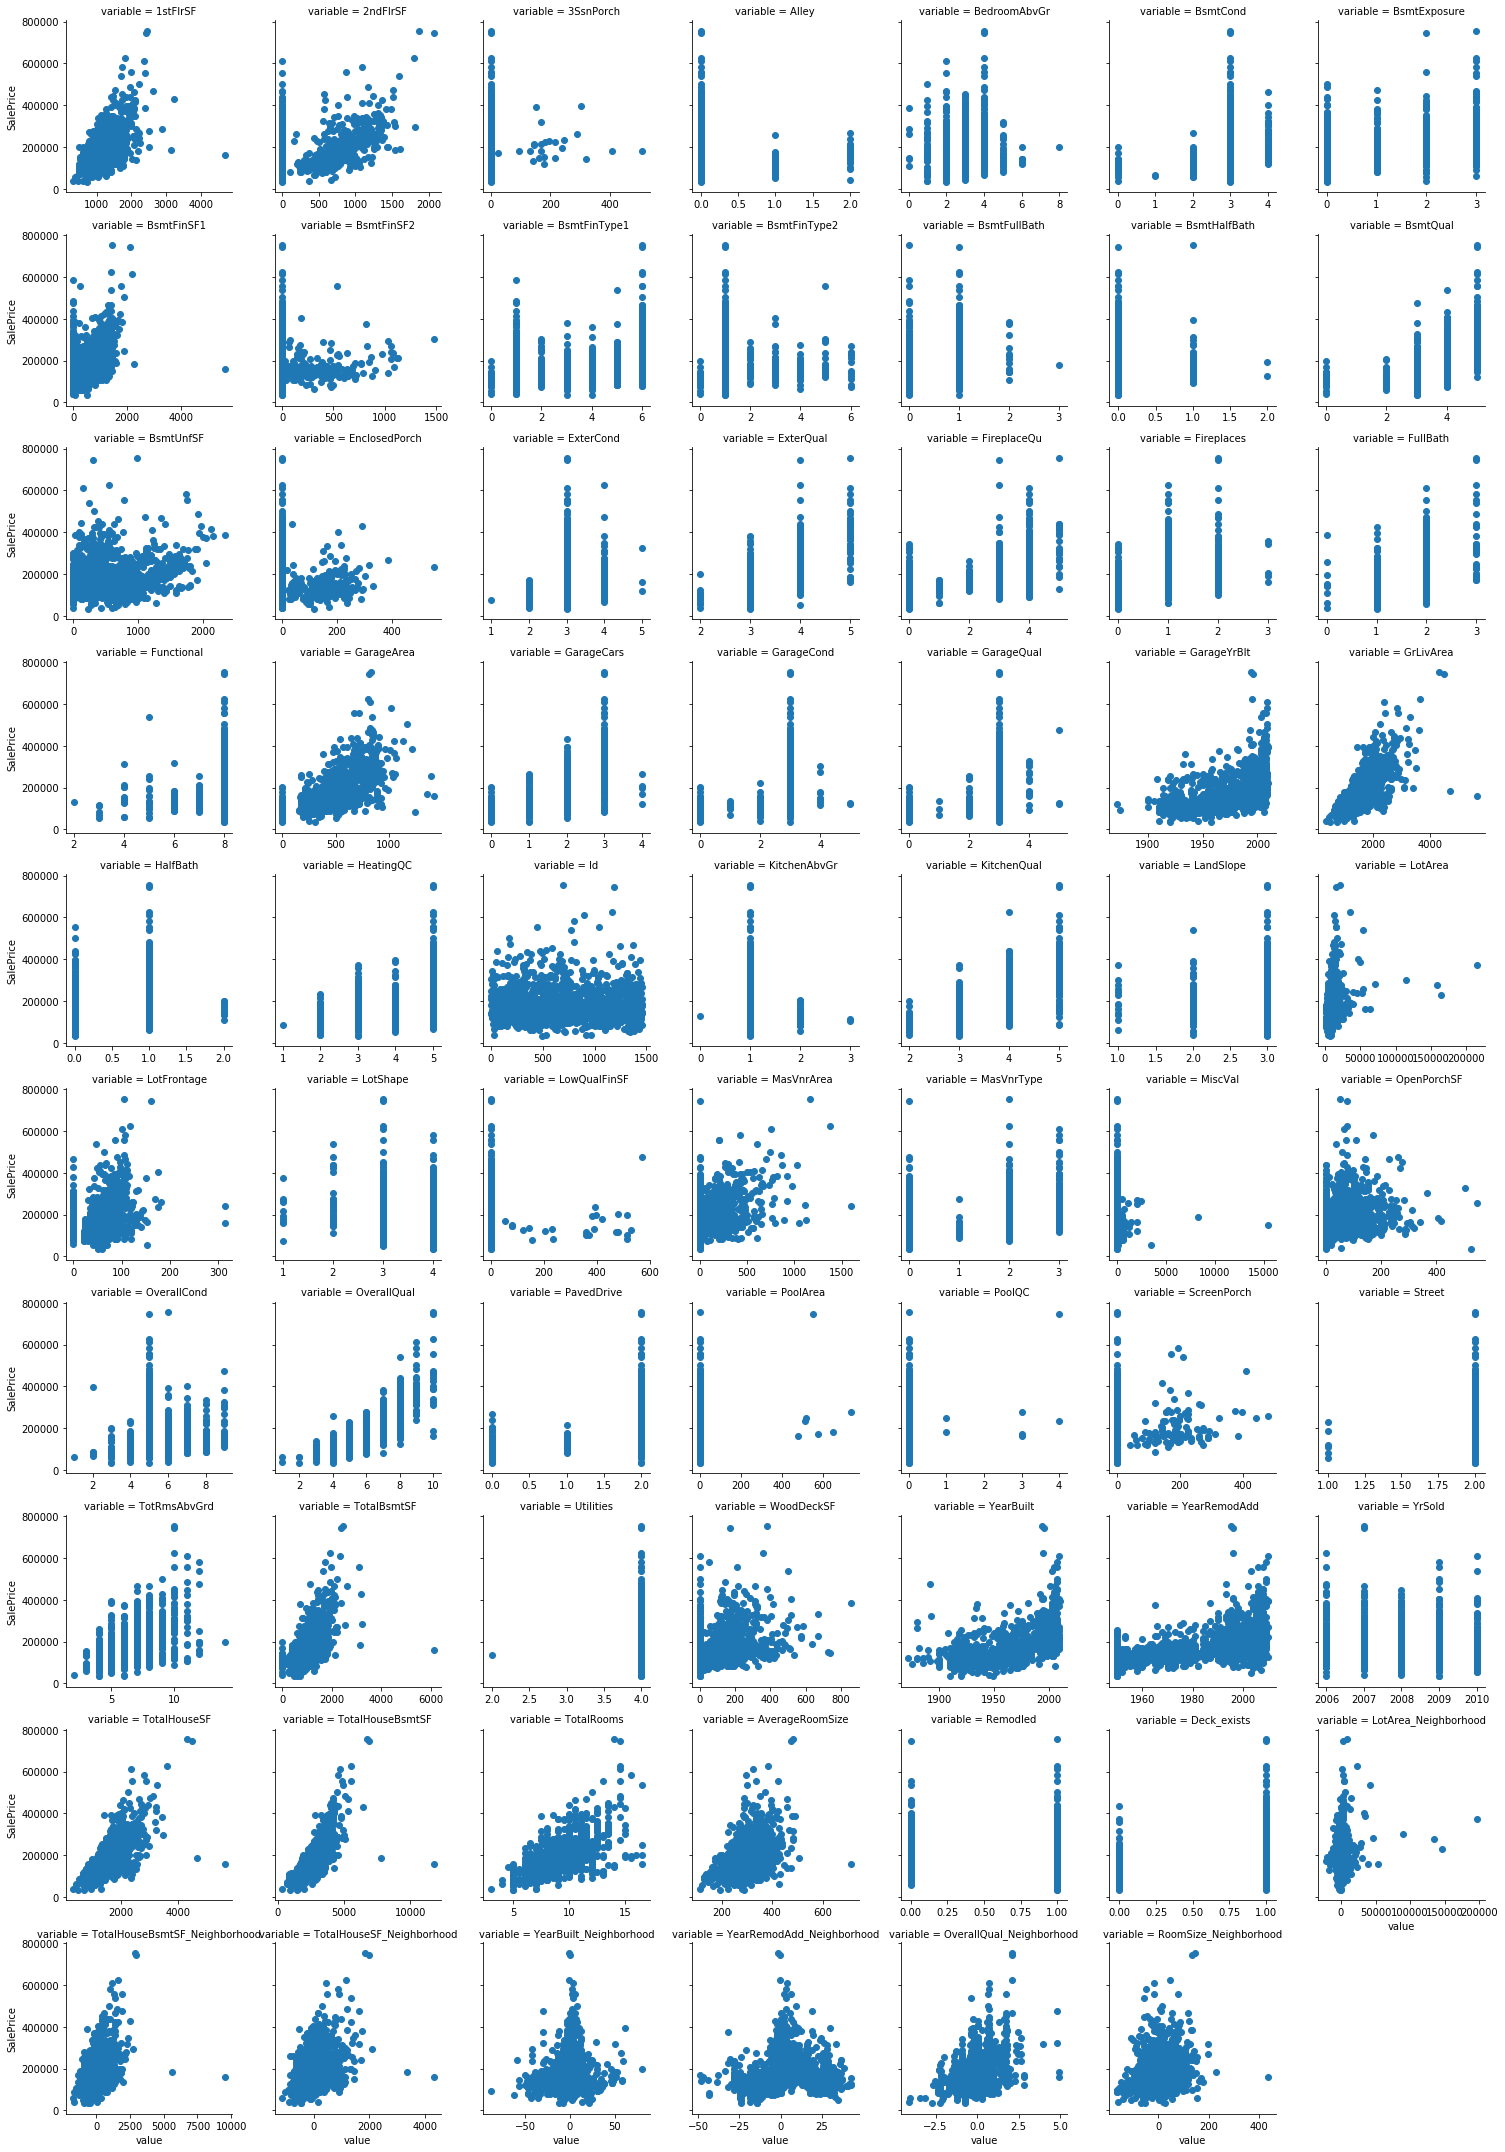

In [10]:
df_grid = df_train.select_dtypes(include='number')
df_grid = df_grid[df_grid.SalePrice.notnull()].melt(id_vars='SalePrice')
g = sns.FacetGrid(df_grid, col='variable', col_wrap=7, sharex=False)
g.map(plt.scatter, 'value', 'SalePrice')

**Create polynomial features based on the relationship determined above**

In [11]:
# Create new features
# Polynomials on features that appear to not be linearly related to SalePrice
df_train["BsmtCond-s2"] = df_train["BsmtCond"]**2
df_train["BsmtFinSF1-s2"] = df_train["BsmtFinSF1"]**2
df_train["BsmtQual-s2"] = df_train["BsmtQual"]**2
df_train["ExterCond-s3"] = df_train["ExterCond"]**3
df_train["ExterQual-s2"] = df_train["ExterQual"]**2
df_train["Fireplaces-s3"] = df_train["Fireplaces"]**3
df_train["FullBath-s2"] = df_train["FullBath"]**2
df_train["Functional-s2"] = df_train["Functional"]**2
df_train["GarageCars-s3"] = df_train["GarageCars"]**3
df_train["GarageYrBlt-s2"] = df_train["GarageYrBlt"]**2
df_train["HeatingQC-s2"] = df_train["HeatingQC"]**2
df_train["OverallQual-s2"] = df_train["OverallQual"]**2
df_train["YearBuilt-s2"] = df_train["YearBuilt"]**2
df_train["YearRemodAdd-s2"] = df_train["YearRemodAdd"]**2
df_train["YearBuilt_Neighborhood-s3"] = df_train["YearBuilt_Neighborhood"]**3
df_train["YearRemodAdd_Neighborhood-s3"] = df_train[
    "YearRemodAdd_Neighborhood"]**3

# # Polynomials on top features
# df_train["OverallQual-s2"] = df_train["OverallQual"]**2
# df_train["OverallQual-s3"] = df_train["OverallQual"]**3
# df_train["OverallQual-Sq"] = np.sqrt(df_train["OverallQual"])
# df_train["TotalHouseBsmtSF-2"] = df_train["TotalHouseBsmtSF"]**2
# df_train["TotalHouseBsmtSF-3"] = df_train["TotalHouseBsmtSF"]**3
# df_train["TotalHouseBsmtSF-Sq"] = np.sqrt(df_train["TotalHouseBsmtSF"])
# df_train["GrLivArea-2"] = df_train["GrLivArea"]**2
# df_train["GrLivArea-3"] = df_train["GrLivArea"]**3
# df_train["GrLivArea-Sq"] = np.sqrt(df_train["GrLivArea"])
# df_train["ExterQual-2"] = df_train["ExterQual"]**2
# df_train["ExterQual-3"] = df_train["ExterQual"]**3
# df_train["ExterQual-Sq"] = np.sqrt(df_train["ExterQual"])
# df_train["GarageCars-2"] = df_train["GarageCars"]**2
# df_train["GarageCars-3"] = df_train["GarageCars"]**3
# df_train["GarageCars-Sq"] = np.sqrt(df_train["GarageCars"])
# df_train["KitchenQual-2"] = df_train["KitchenQual"]**2
# df_train["KitchenQual-3"] = df_train["KitchenQual"]**3
# df_train["KitchenQual-Sq"] = np.sqrt(df_train["KitchenQual"])
# df_train["TotalBsmtSF-2"] = df_train["TotalBsmtSF"]**2
# df_train["TotalBsmtSF-3"] = df_train["TotalBsmtSF"]**3
# df_train["TotalBsmtSF-Sq"] = np.sqrt(df_train["TotalBsmtSF"])

**Add some interaction features**

In [12]:
# Add some interaction features
df_train['OverallQual_TotalHouseBsmtSF'] = df_train["OverallQual"] * df_train[
    "TotalHouseBsmtSF"]
df_train['OverallQual_GrLivArea'] = df_train["OverallQual"] * df_train[
    "GrLivArea"]
df_train['OverallQual_KitchenQual'] = df_train["OverallQual"] * df_train[
    "KitchenQual"]
df_train['OverallQual_OverallCond'] = df_train["OverallQual"] * df_train[
    "OverallCond"]
df_train['TotalHouseBsmtSF_GarageCars'] = df_train["GarageCars"] * df_train[
    "TotalHouseBsmtSF"]
df_train['OverallQual_ExterQual'] = df_train["OverallQual"] * df_train[
    "ExterQual"]
df_train['OverallQual_AverageRoomSize'] = df_train["OverallQual"] * df_train[
    "AverageRoomSize"]
df_train['OverallQual_BsmtQual'] = df_train["OverallQual"] * df_train[
    "BsmtQual"]
df_train['AverageRoomSize_BsmtQual'] = df_train["AverageRoomSize"] * df_train[
    "BsmtQual"]
df_train['OverallQual_YearBuilt'] = df_train["OverallQual"] * df_train[
    "YearBuilt"]
df_train['AverageRoomSize_YearBuilt'] = df_train["AverageRoomSize"] * df_train[
    "YearBuilt"]
df_train['AverageRoomSize_TotalHouseBsmtSF'] = df_train[
    "AverageRoomSize"] * df_train["TotalHouseBsmtSF"]

**Drop data or features according to reasons below**

In [13]:
# Drop 949 as has a basement but NA for exposure
df_train.drop(948, inplace=True)
# Drop 1380 as no electrical
df_train.drop(1379, inplace=True)
# Drop those entries that have lot area larger than 100000ft (but keep all "test" data)
df_train = df_train[(df_train['LotArea'] < 100000) | (
    df_train['Id'].isin(df_test["Id"]))]
# Drop MSSubClass as it's included in YearBuilt, HouseStyle
df_train.drop('MSSubClass', axis=1, inplace=True)
# Drop GarageArea as there is already a correlated feature in GarageCars
df_train.drop('GarageArea', axis=1, inplace=True)
# Drop GarageCond as there is already a correlated feature in GarageQual
df_train.drop('GarageCond', axis=1, inplace=True)
# Drop TotalHouseSF as there is already a correlated feature in TotalHouseBsmtSF
df_train.drop('TotalHouseSF', axis=1, inplace=True)

**Make combined one-hot for the Condition and Exterior fields**

In [14]:
# Make combined one-hot for the Condition and Exterior fields
df_train[['Condition1', 'Condition2']].stack().str.get_dummies().any(
    level=0).astype('int').add_prefix('Condition_')
df_train[['Exterior1st', 'Exterior2nd']].stack().str.get_dummies().any(
    level=0).astype('int').add_prefix('Exterior_')
df_train.drop(
    ['Exterior1st', 'Exterior2nd', 'Condition1', 'Condition2'],
    axis=1,
    inplace=True)

**Remove skewness, extract target variable, and make dummies**

In [15]:
# Extract target variable
y_SalePrice = df_train.SalePrice.dropna()
y_SalePrice_deskewed = boxcox1p(y_SalePrice, .15)
df_train.drop(['Id', 'SalePrice'], axis=1, inplace=True)

# Get dummies
df_train_cat = pd.get_dummies(
    df_train.select_dtypes(exclude='number'), drop_first=True)

# Get numerical features
df_train_num = df_train.select_dtypes(include='number').copy()

# Check the skew of all numerical features
skewed_feats = df_train_num.apply(lambda x: st.skew(x.dropna())).sort_values(
    ascending=False)
skewness = pd.DataFrame({'Skew': skewed_feats})
# Drop negative values as they dont work in boxcox1p
negs = df_train_num.apply(lambda x: x.min()).sort_values()
negs = negs[negs < 0].index
skewness.drop(negs, inplace=True)
print(skewness.head(10))
skewness_old = skewness.copy()
skewness = skewness[abs(skewness.Skew) > .75]

print("There are {} skewed numerical features to Box Cox transform".format(
    skewness.shape[0]))

skewed_features = skewness.index
lam = 0.15
for feat in skewed_features:
    df_train_num[feat] = boxcox1p(df_train_num[feat], lam)

                    Skew
MiscVal        21.947774
PoolQC         19.097622
BsmtFinSF1-s2  18.192186
PoolArea       16.880770
LowQualFinSF   12.076090
3SsnPorch      11.364106
Fireplaces-s3   7.670455
KitchenAbvGr    4.297140
BsmtFinSF2      4.159265
Alley           4.133419
There are 52 skewed numerical features to Box Cox transform


In [16]:
# Concat the dummies and numerical features back together
df_train_concat = pd.concat([df_train_num, df_train_cat], axis=1)

**Split out the testing and training data again**

In [17]:
df_test_ready = df_train_concat[df_train_concat.index > 1459].copy()
df_train_ready = df_train_concat[df_train_concat.index <= 1459].copy()

**Make some functions for use in predictions**

In [18]:
def format_good_features(good_feats, df):
    #Format the Dataframe with only the good features selected from the SelectFromModel

    good_feats_index = good_feats.get_support()
    good_feats_columns = df.columns[good_feats_index]

    return df.loc[:, good_feats_columns]


def split_scale(X, y, scaler_function=RobustScaler(), scale=True):
    # train_test_split then scale the features

    X_train, X_test, y_train, y_test = train_test_split(
        X.copy(), y.copy(), test_size=0.3, random_state=42)

    scaler = scaler_function
    if scale == True:
        X_train.loc[:, :] = scaler.fit_transform(X_train.loc[:, :])
        X_test.loc[:, :] = scaler.transform(X_test.loc[:, :])

    return X_train, X_test, y_train, y_test, scaler


def centered_alpha(alpha):
    # Get new alphas for testing centered around previous best alpha

    return np.ravel([
        alpha * .6, alpha * .65, alpha * .7, alpha * .75, alpha * .8,
        alpha * .85, alpha * .9, alpha * .95, alpha, alpha * 1.05, alpha * 1.1,
        alpha * 1.15, alpha * 1.25, alpha * 1.3, alpha * 1.35, alpha * 1.4
    ])


def output_findings(model,
                    name,
                    df_train,
                    y_test,
                    y_train,
                    column_count,
                    y_train_model,
                    y_test_model,
                    boxcoxlambda=.15):
    # Output a plot of important coefficients and show the RMSE for the training and test data

    # Plot important coefficients
    coefs = pd.Series(np.ravel(model.coef_), index=np.ravel(df_train.columns))
    coefs_count = sum(coefs != 0)
    print(name + " picked " + str(coefs_count) + " features and eliminated the other " +  \
          str(column_count-coefs_count) + " features")
    imp_coefs = pd.concat(
        [coefs.sort_values().head(10),
         coefs.sort_values().tail(10)])
    imp_coefs.plot(kind="barh", color='b')
    plt.title("Coefficients in the " + name + " Model")
    plt.show()

    #Show RMSE
    print("RMSE Training Data:",
          np.sqrt(
              mean_squared_error(
                  np.log1p(inv_boxcox1p(y_train, boxcoxlambda)),
                  np.log1p(inv_boxcox1p(y_train_model, boxcoxlambda)))))
    print("RMSE Testing Data: ",
          np.sqrt(
              mean_squared_error(
                  np.log1p(inv_boxcox1p(y_test, boxcoxlambda)),
                  np.log1p(inv_boxcox1p(y_test_model, boxcoxlambda)))))


def get_predictions(model,
                    filename,
                    good_features,
                    df,
                    df_initial_test,
                    scaler,
                    boxcoxlambda=.15,
                    perform_scale=True):
    # Get the predictions on the test data

    # Scale the features
    df_model_test = df
    if perform_scale == True:
        df_model_test.loc[:, :] = scaler.transform(df.loc[:, :])

    # Get right features
    df_model_test = format_good_features(good_features, df)
    # Predict
    predictions = model.predict(df_model_test)
    predictions = pd.DataFrame(
        predictions, index=df_initial_test['Id'], columns=['SalePrice'])
    # Get real prices and save to csv
    predictions = inv_boxcox1p(predictions, boxcoxlambda)
    predictions.to_csv(filename, index_label='Id')
    return predictions


def output_findings_xgb(model,
                        name,
                        df_train,
                        y_test,
                        y_train,
                        column_count,
                        y_train_model,
                        y_test_model,
                        boxcoxlambda=.15):
    # Output a plot of important coefficients and show the RMSE for the training and test data

    # Plot important coefficients
    coefs = pd.Series(
        np.ravel(model.feature_importances_), index=np.ravel(df_train.columns))
    coefs_count = sum(coefs != 0)
    print(name + " picked " + str(coefs_count) + " features and eliminated the other " +  \
          str(column_count-coefs_count) + " features")
    imp_coefs = pd.concat(
        [coefs.sort_values().head(10),
         coefs.sort_values().tail(10)])
    imp_coefs.plot(kind="barh", color='b')
    plt.title("Coefficients in the " + name + " Model")
    plt.show()

    #Show RMSE
    print("RMSE Training Data:",
          np.sqrt(
              mean_squared_error(
                  np.log1p(inv_boxcox1p(y_train, boxcoxlambda)),
                  np.log1p(inv_boxcox1p(y_train_model, boxcoxlambda)))))
    print("RMSE Testing Data: ",
          np.sqrt(
              mean_squared_error(
                  np.log1p(inv_boxcox1p(y_test, boxcoxlambda)),
                  np.log1p(inv_boxcox1p(y_test_model, boxcoxlambda)))))


def mean_of_models(models, filename, index):
    mean_model = pd.concat(models, axis=1)
    mean_model = mean_model.mean(axis=1)
    test_mean = pd.DataFrame(mean_model, index=index, columns=['SalePrice'])
    test_mean.to_csv(filename, index_label='Id')
    return test_mean

**RidgeCV**

Best alpha : 1
Try again for more precision with alphas centered around 1
Best alpha : 0.65
RidgeCV picked 160 features and eliminated the other 8 features


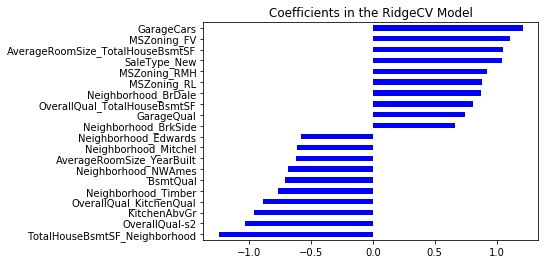

RMSE Training Data: 0.10537713204350277
RMSE Testing Data:  0.11834833483992861


In [19]:
# Set initial variables
alphas = [.3, 1, 2, 5, 10, 100, 200]
cv = KFold(10, True, 42)

# train_test_split and scale
X_train, X_test, y_train, y_test, ridge_scaler = split_scale(
    df_train_ready, y_SalePrice_deskewed)

#Features based on SelectFromModel(RidgeCV)
clf = RidgeCV(alphas=alphas, cv=cv, gcv_mode='auto')
good_feats_ridge = SelectFromModel(
    clf, threshold=".05*mean").fit(X_train, y_train)

# Format training data
X_train = format_good_features(good_feats_ridge, X_train)
X_test = format_good_features(good_feats_ridge, X_test)

# Run RidgeCV to find best alphas
ridge = RidgeCV(
    alphas=alphas, cv=cv, scoring='neg_mean_squared_error', gcv_mode='auto')
ridge.fit(X_train, y_train)
alpha = ridge.alpha_
print("Best alpha :", alpha)

# Get even better alphas
print("Try again for more precision with alphas centered around " + str(alpha))
ridge = RidgeCV(
    alphas=centered_alpha(alpha),
    cv=cv,
    scoring='neg_mean_squared_error',
    gcv_mode='auto')
ridge.fit(X_train, y_train)
alpha = ridge.alpha_
print("Best alpha :", alpha)

# Run predictions
y_train_ridge = ridge.predict(X_train)
y_test_ridge = ridge.predict(X_test)

# Output findings
output_findings(ridge, "RidgeCV", X_train, y_test, y_train,
                len(df_train_ready.columns), y_train_ridge, y_test_ridge)

In [20]:
# Predict and save to file
test_ridge = get_predictions(ridge, 'test_ridge_new.csv', good_feats_ridge,
                             df_test_ready.copy(), df_initial_test,
                             ridge_scaler)

**LassoCV**

C:\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with v

Best alpha : 0.0001
Try again for more precision with alphas centered around 0.0001


C:\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with v

Best alpha : 6e-05
LassoCV picked 125 features and eliminated the other 43 features


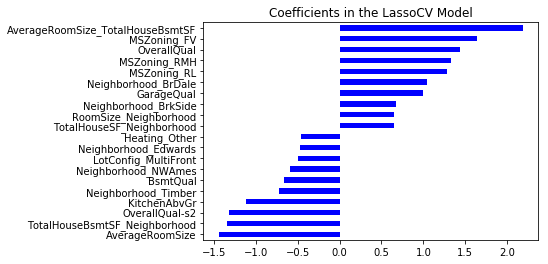

RMSE Training Data: 0.10612344351566798
RMSE Testing Data:  0.11809634048866505


In [21]:
# Set initial variables
alphas = [.0001, .0003, .001, .003, .01, .03]
max_iter = 25000
cv = KFold(10, True, 42)

# train_test_split and scale
X_train, X_test, y_train, y_test, lasso_scaler = split_scale(
    df_train_ready, y_SalePrice_deskewed)

#Features based on SelectFromModel(LassoCV)
clf = LassoCV(alphas=np.ravel(alphas), max_iter=max_iter, cv=cv)
good_feats_lasso = SelectFromModel(
    clf, threshold=".0001*mean").fit(X_train, np.ravel(y_train))

# Format training data
X_train = format_good_features(good_feats_lasso, X_train)
X_test = format_good_features(good_feats_lasso, X_test)

# Run LassoCV to find best alphas
lasso = LassoCV(alphas=np.ravel(alphas), max_iter=max_iter, cv=cv)
lasso.fit(X_train, np.ravel(y_train))
alpha = lasso.alpha_
print("Best alpha :", alpha)

# Get even better alphas
print("Try again for more precision with alphas centered around " + str(alpha))
lasso = LassoCV(
    alphas=np.ravel(centered_alpha(alpha)), max_iter=max_iter, cv=cv)
lasso.fit(X_train, np.ravel(y_train))
alpha = lasso.alpha_
print("Best alpha :", alpha)

# Run predictions
y_train_lasso = lasso.predict(X_train)
y_test_lasso = lasso.predict(X_test)

# Output findings
output_findings(lasso, "LassoCV", X_train, y_test, y_train,
                len(df_train_ready.columns), y_train_lasso, y_test_lasso)

In [22]:
# Predict and save to file
test_lasso = get_predictions(lasso, 'test_lasso_new.csv', good_feats_lasso,
                             df_test_ready.copy(), df_initial_test,
                             lasso_scaler)

**BayesianRidge**

Convergence after  14  iterations
BayesianRidge picked 161 features and eliminated the other 7 features


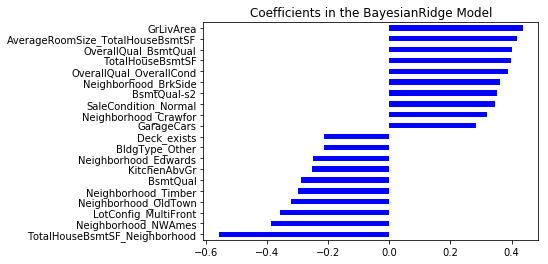

RMSE Training Data: 0.11201308193387198
RMSE Testing Data:  0.11828572888038348


In [23]:
# Set initial variables
n_iter = 1000

# train_test_split and scale
X_train, X_test, y_train, y_test, bayes_scaler = split_scale(
    df_train_ready, y_SalePrice_deskewed)

#Features based on SelectFromModel(BayesianRidge)
clf = BayesianRidge(n_iter=n_iter)
good_feats_bayes = SelectFromModel(
    clf, threshold=".05*mean").fit(X_train, np.ravel(y_train))

# Format training data
X_train = format_good_features(good_feats_bayes, X_train)
X_test = format_good_features(good_feats_bayes, X_test)

# Run BayesianRidge (ran some tests to find best alpha - changing it had no impact)
bayes = BayesianRidge(n_iter=n_iter, verbose=True)
bayes.fit(X_train, np.ravel(y_train))

# Run predictions
y_train_bayes = bayes.predict(X_train)
y_test_bayes = bayes.predict(X_test)

# Output findings
output_findings(bayes, "BayesianRidge", X_train, y_test, y_train,
                len(df_train_ready.columns), y_train_bayes, y_test_bayes)

In [24]:
# Predict and save to file
test_bayes = get_predictions(bayes, 'test_bayes_new.csv', good_feats_bayes,
                             df_test_ready.copy(), df_initial_test,
                             bayes_scaler)

**XGBoost**

{'learning_rate': 0.10226582068864576, 'max_depth': 3, 'min_child_weight': 2.1191354170367784, 'n_estimators': 3711}
XGBoost picked 86 features and eliminated the other 82 features


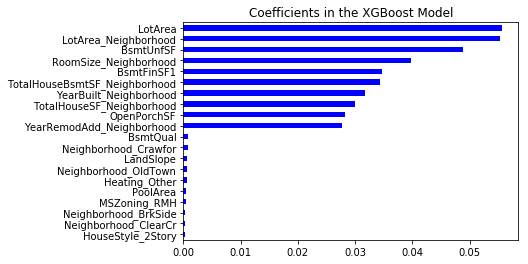

RMSE Training Data: 0.001294702986857846
RMSE Testing Data:  0.12543222080263564


In [25]:
splits = 3

# train_test_split and scale
X_train, X_test, y_train, y_test, xgb_scaler = split_scale(
    df_train_ready, y_SalePrice_deskewed, scale=False)

#Features based on SelectFromModel(BayesianRidge)
clf = XGBRegressor()
good_feats_xgb = SelectFromModel(
    clf, threshold=".01*mean").fit(X_train, np.ravel(y_train))

# Format training data
X_train = format_good_features(good_feats_xgb, X_train)
X_test = format_good_features(good_feats_xgb, X_test)

# XGBRegressor
tscv = KFold(n_splits=splits)
tscv_cv = tscv.split(X_train)
params = {
    "n_estimators": st.randint(1000, 4000),
    "max_depth": st.randint(3, 10),
    "learning_rate": st.uniform(0.05, 0.4),
    "min_child_weight": st.uniform(0.5, 5),
}

xgbr = XGBRegressor()
xgbr = RandomizedSearchCV(xgbr, params, n_iter=10, cv=tscv_cv)
xgbr.fit(X_train, y_train)
print(xgbr.best_params_)

# # Run predictions
# y_train_xgb = xgbrscv.best_estimator_.predict(X_train)
# y_test_xgb = xgbrscv.best_estimator_.predict(X_test)

# # Output findings
# output_findings_xgb(xgbrscv.best_estimator_, "XGBoost", X_train, y_test, y_train, "SalePrice",
#                 y_train_xgb, y_test_xgb)

# xgbr = XGBRegressor(colsample_bytree=0.4603, gamma=0.0468,
#                              learning_rate=0.05, max_depth=3,
#                              min_child_weight=1.7817, n_estimators=2200,
#                              reg_alpha=0.4640, reg_lambda=0.8571,
#                              subsample=0.5213, silent=1,
#                              random_state =7, nthread = -1)
# xgbr.fit(X_train, y_train)

# Run predictions
y_train_xgb = xgbr.predict(X_train)
y_test_xgb = xgbr.predict(X_test)

# Output findings
output_findings_xgb(xgbr.best_estimator_, "XGBoost", X_train, y_test, y_train,
                    len(df_train_ready.columns), y_train_xgb, y_test_xgb)

In [26]:
# Predict and save to file
test_xgb = get_predictions(
    xgbr,
    'test_xgb_new.csv',
    good_feats_xgb,
    df_test_ready.copy(),
    df_initial_test,
    xgb_scaler,
    perform_scale=False)

In [27]:
# Stack predictions and save to file
test_all = mean_of_models([test_xgb, test_lasso, test_ridge, test_bayes],
                          'test_new_all.csv', df_initial_test['Id'])